## Libraries to import

In [1]:
!pip install tensorflow
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

Mounted at /content/drive


## Importing the dataset

In [18]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_1h.csv')

### Feature engineering

In [19]:
# adding features that make more sense than raw data
# all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
# all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
# all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

# all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
# all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
# all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

In [20]:
all_prices = all_prices.dropna().drop(columns=['Datetime'])

In [21]:
all_prices.head()

,Gold,Silver,CAD
0,2105.699951,25.865,0.740730
1,2105.699951,25.865,0.740466
2,2105.699951,25.865,0.740297
3,2105.699951,25.865,0.739809
4,2105.699951,25.865,0.739973


In [22]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12535 entries, 0 to 12534
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gold    12535 non-null  float64
 1   Silver  12535 non-null  float64
 2   CAD     12535 non-null  float64
dtypes: float64(3)
memory usage: 293.9 KB


In [23]:
all_prices.describe()

,Gold,Silver,CAD
count,12535.000000,12535.000000,12535.000000
mean,2839.498462,32.683278,0.723833
std,605.060869,7.133482,0.015187
min,1989.300049,22.014999,0.676535
25%,2358.399902,28.615000,0.714372
50%,2679.100098,31.420000,0.726507
75%,3338.300049,34.887499,0.735056
max,4394.299805,59.095001,0.758392


In [24]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)
scaled

array([[0.04839913, 0.10382956, 0.78423446],
       [0.04839913, 0.10382956, 0.78101817],
       [0.04839913, 0.10382956, 0.77894219],
       ...,
       [0.94124748, 0.96561485, 0.46305096],
       [0.93904382, 0.96642388, 0.46305096],
       [0.9396259 , 0.96588459, 0.46305096]])

In [25]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [26]:
max_window = 60

X, y = create_sequences(scaled, max_window)
X.shape

(12475, 60, 3)

### Train/test split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

## GRU implementation

### Hyperparameter tuning

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [ ]:
def model_builder(hp):
    model = keras.Sequential([
        keras.layers.GRU(
            units=hp.Int("units_1", min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(hp.Int("window", min_value=10, max_value=100, step=10), 3),
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg", values=[1e-6, 1e-5, 1e-4]))
        ),
        keras.layers.Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.GRU(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg2", [1e-6, 1e-5, 1e-4])),
        ),
        keras.layers.Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.Dense(3, activation="relu") #output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),\
        loss="mse",
        metrics=[rmse, mae, mape]
    )

    return model

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_rmse", direction="min"),
    max_epochs=40,
    max_consecutive_failed_trials=5,
    seed=42,
    directory="tuning_results",
    project_name="gold_silver_cad",
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [ ]:
tuner.search(x=X_train, y=y_train, validation_split=0.15, callbacks=[stop_early])

Trial 90 Complete [00h 00m 48s]
val_rmse: 0.00689623411744833

Best val_rmse So Far: 0.00500192865729332
Total elapsed time: 00h 32m 15s


### Metrics evaluation of the best model

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_model.save('gru_1h.keras')
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 40, 128)        │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,515 (345.76 KB)

 Trainable params: 88,515 (345.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units_1': 128,
 'window': 40,
 'l2_reg': 1e-06,
 'dropout_1': 0.1,
 'units_2': 64,
 'l2_reg2': 1e-06,
 'dropout_2': 0.15000000000000002,
 'learning_rate': 0.001,
 'tuner/epochs': 40,
 'tuner/initial_epoch': 14,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0067'}

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model = best_model

y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("MAPE:", mape_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE: 36.18532618629252
MAE : 17.952411488336722
MAPE: 0.00738373486652475


In [ ]:
baseline = scaler.inverse_transform(X_test[:, -1, :])

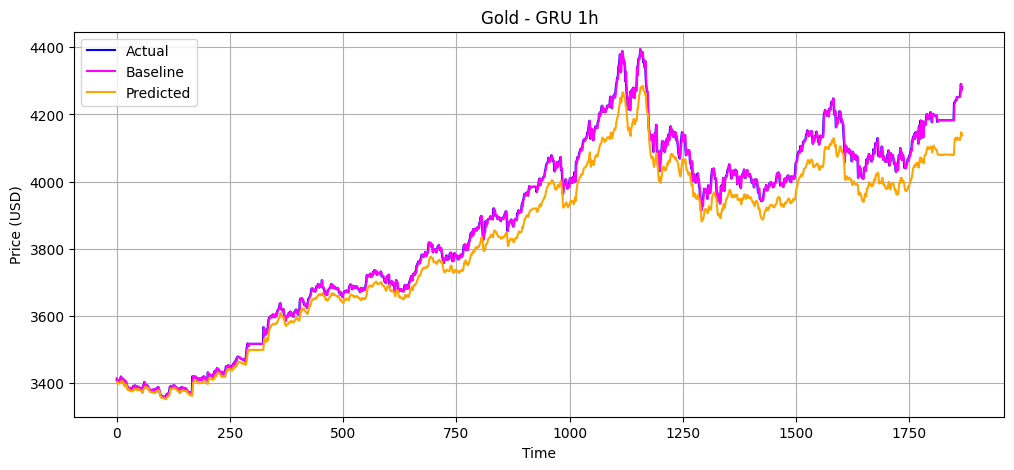

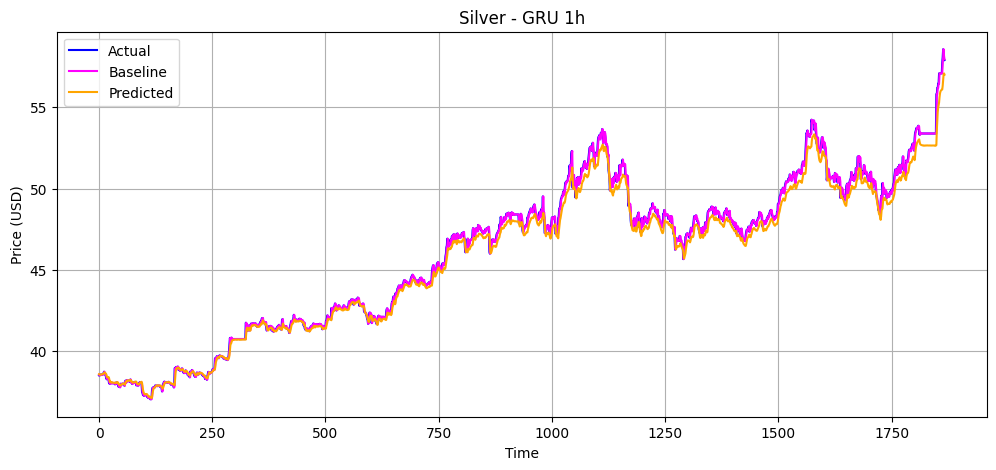

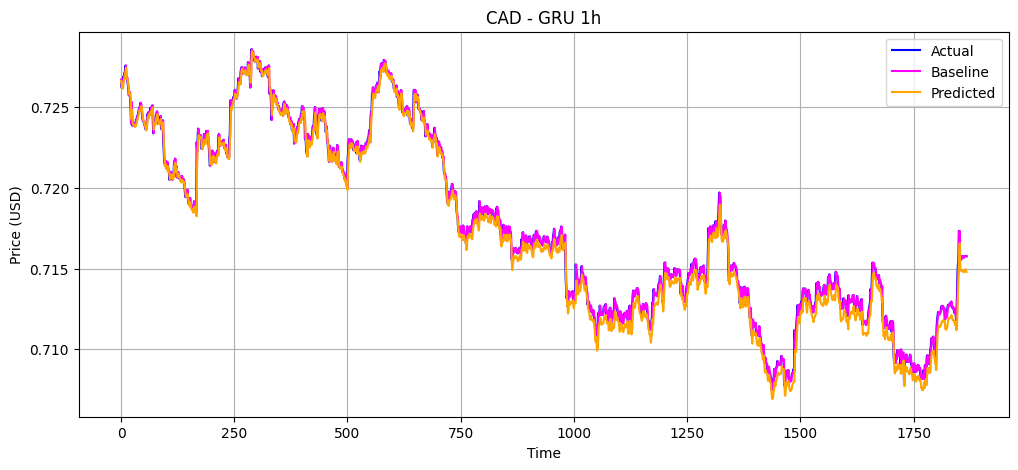

In [ ]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.title(f"{asset_name} - GRU 1h")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [ ]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

Gold
 MAE : 53.46082470912239
 RMSE: 62.67270980018107
 MAPE: 1.3326798634889825

Silver
 MAE : 0.39591418803376327
 RMSE: 0.5147227777144888
 MAPE: 0.8132256588500315

CAD
 MAE : 0.0004955678540072548
 RMSE: 0.0006241405713456466
 MAPE: 0.06921493761841031



### Mean + std

To ensure the model did not randomly achieve good results with the test set

In [13]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [14]:
# {'units_1': 128,
#  'window': 40,
#  'l2_reg': 1e-06,
#  'dropout_1': 0.1,
#  'units_2': 64,
#  'l2_reg2': 1e-06,
#  'dropout_2': 0.15000000000000002,
#  'learning_rate': 0.001,
#  'tuner/epochs': 40,
#  'tuner/initial_epoch': 14,
#  'tuner/bracket': 2,
#  'tuner/round': 2,
#  'tuner/trial_id': '0067'}

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mae_arr = []
rmse_arr = []
mape_arr = []

for i in range(10):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

  model = keras.Sequential([
      keras.layers.GRU(
          units=128,
          return_sequences=True,
          input_shape=(40, 3),
          kernel_regularizer=keras.regularizers.l2(1e-06)
      ),
      keras.layers.Dropout(0.1),
      keras.layers.GRU(
          units=64,
          return_sequences=False,
          kernel_regularizer=keras.regularizers.l2(1e-06),
      ),
      keras.layers.Dropout(0.15000000000000002),
      keras.layers.Dense(3, activation="relu") #output
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(0.001),
      loss='mse',
      metrics=[rmse, mae, mape]
  )

  model.fit(X_train, y_train, epochs=40)

  y_pred = model.predict(X_test)

  y_pred_inv = scaler.inverse_transform(y_pred)
  y_test_inv = scaler.inverse_transform(y_test)

  rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
  mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
  mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

  rmse_arr.append(rmse_val)
  mae_arr.append(mae_val)
  mape_arr.append(mape_val)

  print("RMSE:", rmse_val)
  print("MAE :", mae_val)
  print("MAPE:", mape_val)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0118 - mae: 0.0651 - mape: 3538.4648 - rmse: 0.0813
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0016 - mae: 0.0299 - mape: 18094.7949 - rmse: 0.0385
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0012 - mae: 0.0256 - mape: 176660.1719 - rmse: 0.0335
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.7629e-04 - mae: 0.0226 - mape: 39241.4844 - rmse: 0.0300
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.5676e-04 - mae: 0.0210 - mape: 25496.7246 - rmse: 0.0281
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.6517e-04 - mae: 0.0198 - mape: 12111.3936 - rmse: 0.0264
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 6.4147e-04 - mae: 0.0178 - mape: 25535.0312 - rmse: 0.0241
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.8005e-04 - mae: 0.0170 - mape: 33864.4297 - rmse: 0.0229
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0137 - mae: 0.0660 - mape: 60271.2227 - rmse: 0.0830
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0015 - mae: 0.0290 - mape: 22059.6074 - rmse: 0.0379
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - mae: 0.0250 - mape: 7253.9370 - rmse: 0.0329
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.5650e-04 - mae: 0.0224 - mape: 46479.6445 - rmse: 0.0297
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 8.3050e-04 - mae: 0.0206 - mape: 12555.1211 - rmse: 0.0276
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.5994e-04 - mae: 0.0196 - mape: 61647.4336 - rmse: 0.0264
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.5153e-04 - mae: 0.0180 - mape: 14700.6680 - rmse: 0.0243
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.8483e-04 - mae: 0.0168 - mape: 1359.8464 - rmse: 0.0229
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.2183e-04

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0220 - mae: 0.0790 - mape: 413655.9688 - rmse: 0.1020
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0014 - mae: 0.0279 - mape: 83290.4922 - rmse: 0.0364
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0012 - mae: 0.0248 - mape: 94006.8906 - rmse: 0.0326
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.5210e-04 - mae: 0.0223 - mape: 47763.4180 - rmse: 0.0295
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.4379e-04 - mae: 0.0207 - mape: 20521.2012 - rmse: 0.0278
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 7.4958e-04 - mae: 0.0195 - mape: 29282.5312 - rmse: 0.0261
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.2589e-04 - mae: 0.0175 - mape: 4218.5688 - rmse: 0.0237
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.6998e-04 - mae: 0.0168 - mape: 59346.0469 - rmse: 0.0226
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.0707e

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0175 - mae: 0.0779 - mape: 34993.6211 - rmse: 0.0959
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0015 - mae: 0.0282 - mape: 20671.4648 - rmse: 0.0366
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0011 - mae: 0.0248 - mape: 52375.8242 - rmse: 0.0323
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 9.5168e-04 - mae: 0.0224 - mape: 13621.1650 - rmse: 0.0296
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.2340e-04 - mae: 0.0207 - mape: 40991.8672 - rmse: 0.0275
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.2382e-04 - mae: 0.0193 - mape: 7828.1499 - rmse: 0.0257
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.4827e-04 - mae: 0.0181 - mape: 36051.7344 - rmse: 0.0242
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4973e-04 - mae: 0.0164 - mape: 20243.2676 - rmse: 0.0222
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.0752e-04

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0227 - mae: 0.0990 - mape: 20359.5684 - rmse: 0.1318
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0015 - mae: 0.0286 - mape: 48812.4922 - rmse: 0.0372
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - mae: 0.0248 - mape: 73173.8125 - rmse: 0.0328
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 9.7032e-04 - mae: 0.0226 - mape: 1190.9525 - rmse: 0.0299
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.4627e-04 - mae: 0.0208 - mape: 14936.4111 - rmse: 0.0279
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 7.1372e-04 - mae: 0.0190 - mape: 64343.4219 - rmse: 0.0255
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.4181e-04 - mae: 0.0178 - mape: 53470.7188 - rmse: 0.0241
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.7500e-04 - mae: 0.0168 - mape: 5770.6387 - rmse: 0.0227
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.3155

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0094 - mae: 0.0607 - mape: 18406.2441 - rmse: 0.0756
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0015 - mae: 0.0284 - mape: 18934.5430 - rmse: 0.0369
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0011 - mae: 0.0247 - mape: 34039.5664 - rmse: 0.0323
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.4499e-04 - mae: 0.0223 - mape: 32748.5195 - rmse: 0.0295
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 8.3388e-04 - mae: 0.0207 - mape: 73851.2969 - rmse: 0.0277
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.0345e-04 - mae: 0.0188 - mape: 46506.7344 - rmse: 0.0253
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.4990e-04 - mae: 0.0180 - mape: 10756.7236 - rmse: 0.0243
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.7023e-04 - mae: 0.0166 - mape: 27674.2559 - rmse: 0.0226
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 5.1606e-0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0225 - mae: 0.0902 - mape: 4723.9067 - rmse: 0.1103
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0014 - mae: 0.0281 - mape: 20497.1895 - rmse: 0.0363
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - mae: 0.0250 - mape: 49326.5156 - rmse: 0.0326
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.6020e-04 - mae: 0.0226 - mape: 35811.0352 - rmse: 0.0297
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.4730e-04 - mae: 0.0209 - mape: 98560.9844 - rmse: 0.0279
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 7.5454e-04 - mae: 0.0197 - mape: 28509.6445 - rmse: 0.0262
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.6492e-04 - mae: 0.0184 - mape: 62868.2500 - rmse: 0.0246
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.0500e-04 - mae: 0.0174 - mape: 57446.2383 - rmse: 0.0233
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.4382e-04

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0108 - mae: 0.0638 - mape: 3827.3879 - rmse: 0.0795
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0016 - mae: 0.0297 - mape: 33063.3477 - rmse: 0.0383
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - mae: 0.0251 - mape: 6054.2300 - rmse: 0.0330
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0010 - mae: 0.0231 - mape: 24102.9648 - rmse: 0.0304
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 8.1984e-04 - mae: 0.0207 - mape: 36993.8672 - rmse: 0.0274
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.4547e-04 - mae: 0.0195 - mape: 13641.3457 - rmse: 0.0261
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.5339e-04 - mae: 0.0182 - mape: 14481.4482 - rmse: 0.0243
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.8688e-04 - mae: 0.0171 - mape: 6719.2515 - rmse: 0.0230
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.0829e-04 - ma

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0142 - mae: 0.0699 - mape: 1021.1176 - rmse: 0.0884
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0016 - mae: 0.0295 - mape: 6169.3281 - rmse: 0.0382
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0012 - mae: 0.0256 - mape: 64099.0352 - rmse: 0.0336
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0010 - mae: 0.0232 - mape: 70743.5078 - rmse: 0.0307
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.5754e-04 - mae: 0.0210 - mape: 90397.7734 - rmse: 0.0280
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.4830e-04 - mae: 0.0194 - mape: 42379.5039 - rmse: 0.0261
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.6815e-04 - mae: 0.0183 - mape: 6011.6274 - rmse: 0.0246
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 5.8715e-04 - mae: 0.0170 - mape: 29098.5918 - rmse: 0.0230
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.1896e-04 - ma

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0134 - mae: 0.0696 - mape: 59178.9219 - rmse: 0.0867
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0015 - mae: 0.0292 - mape: 21713.8535 - rmse: 0.0376
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - mae: 0.0253 - mape: 74918.0938 - rmse: 0.0329
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.7942e-04 - mae: 0.0228 - mape: 5538.9434 - rmse: 0.0300
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 8.6307e-04 - mae: 0.0211 - mape: 11764.5469 - rmse: 0.0281
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 7.4655e-04 - mae: 0.0195 - mape: 47291.1172 - rmse: 0.0261
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.2260e-04 - mae: 0.0178 - mape: 5514.4438 - rmse: 0.0237
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.6380e-04 - mae: 0.0168 - mape: 24163.3594 - rmse: 0.0225
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.2099e-0

In [16]:
mae_arr = np.array(mae_arr)
rmse_arr = np.array(rmse_arr)
mape_arr = np.array(mape_arr)

print("RMSE: mean =", np.mean(rmse_arr), '|| std dev =', np.std(rmse_arr))
print("MAE : mean =", np.mean(mae_arr), '|| std dev =', np.std(mae_arr))
print("MAPE: mean =", np.mean(mape_arr), '|| std dev =', np.std(mape_arr))

RMSE: mean = 40.96897008848818 || std dev = 15.526187200628419
MAE : mean = 21.067521325100497 || std dev = 9.027193439248858
MAPE: mean = 0.010016154825711675 || std dev = 0.004496661202731738


### Final model

Model trained on all the dataset set to be used for future predictions

In [28]:
model = keras.Sequential([
    keras.layers.GRU(
        units=128,
        return_sequences=True,
        input_shape=(40, 3),
        kernel_regularizer=keras.regularizers.l2(1e-06)
    ),
    keras.layers.Dropout(0.1),
    keras.layers.GRU(
        units=64,
        return_sequences=False,
        kernel_regularizer=keras.regularizers.l2(1e-06),
    ),
    keras.layers.Dropout(0.15000000000000002),
    keras.layers.Dense(3, activation="relu") #output
])

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='mse',
    metrics=[rmse, mae, mape]
)

model.fit(X, y, epochs=40)

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


390/390 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0121 - mae: 0.0656 - mape: 35847.8984 - rmse: 0.0829
Epoch 2/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0018 - mae: 0.0313 - mape: 19727.8984 - rmse: 0.0410
Epoch 3/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0014 - mae: 0.0273 - mape: 16183.9912 - rmse: 0.0360
Epoch 4/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0012 - mae: 0.0251 - mape: 17549.6113 - rmse: 0.0334
Epoch 5/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 9.7834e-04 - mae: 0.0225 - mape: 28521.9668 - rmse: 0.0300
Epoch 6/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 8.8614e-04 - mae: 0.0212 - mape: 56640.8984 - rmse: 0.0285
Epoch 7/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 8.0017e-04 - mae: 0.0199 - mape: 21595.6523 - rmse: 0.0271
Epoch 8/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 6.7443e-04 - mae: 0.0182 - mape: 37632.5547 - rmse: 0.0247
Epoch 9/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 6.0517e-04 -

In [29]:
model.save('gru_1h.keras')